<a href="https://colab.research.google.com/github/naguzmans/opportunistic-atm/blob/master/03_Download_Metadata_Table.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mount Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Install Dependencies

In [2]:
!pip install holidays
%cd /content/drive/MyDrive/opportunistic-utm/

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
/content/drive/MyDrive/opportunistic-utm


# Check DarkSky API

In [5]:
import requests

# Checks API using a random timestamp
timestamp = 1526745600
key = '00fa20d9a815fab822b59c022ba8f4e5'
location = '51.87626460000001,-0.3717470999999932'
exclude = 'exclude=minutely,hourly,daily,alerts,flags'
units = 'si'
endpoint = f'https://api.darksky.net/forecast/{key}/{location},{timestamp}?{exclude}&{units}'
requests.get(endpoint).json()['currently']

{'apparentTemperature': 19.02,
 'dewPoint': 4.03,
 'humidity': 0.37,
 'temperature': 19.02,
 'time': 1526745600,
 'visibility': 10.003,
 'windBearing': 89,
 'windSpeed': 10.38}

# Define Metadata Functions

In [ ]:
from datetime import datetime
import numpy as np
import holidays
import math
import requests

# Transforms Unix time to UTC
def epoch_to_utc(hour_in_unix_time):
  return datetime.utcfromtimestamp(hour_in_unix_time)

# Gets month number
def get_month(unix_timestamp):
  return unix_timestamp.month

# Gets week number
def get_day(unix_timestamp):
  return unix_timestamp.weekday()

# Checks if given timestamp is holiday or not in the UK
def is_holiday(timestamp):
  uk_holidays = holidays.UK()

  if timestamp in uk_holidays:
    return 1
  else:
    return 0

# Gets weather information using DarkSky API
def get_weather(unix_timestamp, size = 100):
  timestamp = str(unix_timestamp)
  key = '00fa20d9a815fab822b59c022ba8f4e5'
  location = '51.87626460000001,-0.3717470999999932'
  exclude = 'exclude=minutely,hourly,daily,alerts,flags'
  units = 'si'
  endpoint = f'https://api.darksky.net/forecast/{key}/{location},{timestamp}?{exclude}&{units}'
  response = requests.get(endpoint).json()['currently']

  try:
    temperature = np.reshape(response['temperature'], (1,1))
  except:
    temperature = np.reshape(np.nan, (1,1))

  try:
    wind_bearing = np.reshape(response['windBearing'], (1,1))
  except:
    wind_bearing = np.reshape(np.nan, (1,1))

  try:
    wind_speed = np.reshape(response['windSpeed'], (1,1))
  except:
    wind_speed = np.reshape(np.nan, (1,1))
  
  try:
    visibility = np.reshape(response['visibility'], (1,1))
  except:
    visibility = np.reshape(np.nan, (1,1))

  try:
    cloud_cover = np.reshape(response['cloudCover'], (1,1))
  except:
    cloud_cover = np.reshape(np.nan, (1,1))

  weather_metadata = np.concatenate((temperature, wind_bearing, wind_speed, visibility, cloud_cover), axis = 1)
  return np.tile(weather_metadata, (size, 1))

# Blank spacer if data is no a multiple of five
def spacer(units):
  return np.zeros(units)

# Compile metadata
def metadata(timestamp, size = 100, tiled = False):
  utc_timestamp = epoch_to_utc(timestamp)

  # Hot-encode day and month
  months = np.zeros(12)
  days = np.zeros(7)
  months[get_month(utc_timestamp)-1] = 1
  days[get_day(utc_timestamp)] = 1
  months_tile = np.tile(months, (size, 1))
  days_tile = np.tile(days, (size, 1))

  # Hot-enconde if holiday is true
  holiday_tile = np.tile(is_holiday(utc_timestamp), (size, 1))

  # Weather
  weather_tile = get_weather(timestamp, size=size)

  # Spacer if needed
  spacer_tile = np.tile(spacer(1), (size, 1))

  tiled_metadata = np.concatenate((months_tile, days_tile, holiday_tile, weather_tile), axis = 1)

  # Merge together
  if tiled == True:
    width = math.ceil(size/tiled_metadata.shape[-1])
    tiled_metadata = np.tile(tiled_metadata, width)[:,:size]
    return tiled_metadata
  elif tiled == False:
    return tiled_metadata[0]

# Test Sample

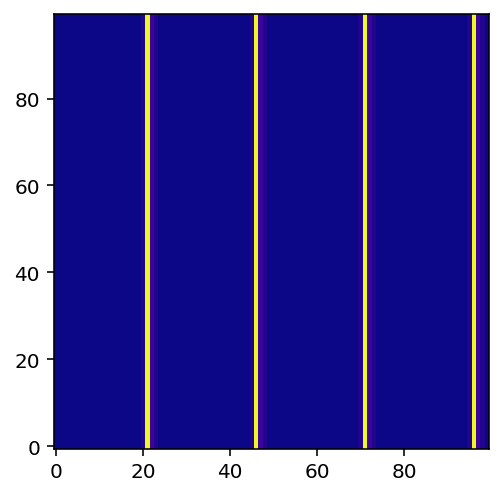

In [ ]:
# Plot as a tile of (100, 100)
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

plot_metadata = metadata(1546339684, tiled = True)
plt.imshow(plot_metadata, origin='lower', cmap='plasma')
plt.show()

In [ ]:
# Check metadata shape
metadata(1517440800)

array([1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       1.9800e+00, 2.3500e+02, 2.0670e+01, 1.0003e+01, 5.0000e-02])

# Download Metadata

In [ ]:
from datetime import timezone
from datetime import datetime
from tqdm import tqdm
import pandas as pd
import numpy as np
import os

# Download data manually as needed
year = 2018
days = np.linspace(1,31,31)

columns = ['time', 'hour', 'jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', \
           'oct', 'nov', 'dec', 'mon', 'tue', 'wed', 'thu', 'fri', 'sat', 'sun',\
           'hol', 'temp', 'wbear', 'wspeed', 'visib', 'ccover']
metadata_df = pd.DataFrame(columns = columns)

# Iterates through each day in a given month
for month in tqdm(range(1, 13)):
  try:
    for day in days:
      unix_hour = int(datetime(year, month, int(day), 0, 0, 0).replace(tzinfo=timezone.utc).timestamp())
      for i in range(0, 24):
        for j in range(3):
          base_hour = np.reshape(np.array(unix_hour), (1,))
          next_20 = np.reshape(np.array(unix_hour + j * 1200), (1,))
          metadata_array = np.concatenate((next_20, base_hour, metadata(unix_hour + j * 1200)))
          metadata_df = metadata_df.append(pd.DataFrame(metadata_array.reshape(1,-1), columns=columns))
        unix_hour += 3600
    metadata_df = metadata_df.reset_index(drop=True)
  except:
    pass

# Save file
filepath = f'dataset/00_results/metadata_{year}.xlsx'
metadata_df.to_excel(filepath, index=False)

 17%|█▋        | 2/12 [08:04<40:03, 240.38s/it]

End of Month


 33%|███▎      | 4/12 [16:21<32:40, 245.10s/it]

End of Month


 50%|█████     | 6/12 [24:29<24:24, 244.01s/it]

End of Month


 75%|███████▌  | 9/12 [36:50<12:17, 245.76s/it]

End of Month


 92%|█████████▏| 11/12 [45:08<04:07, 247.16s/it]

End of Month


100%|██████████| 12/12 [49:19<00:00, 246.63s/it]


# Process Metadata

**Load data**

In [7]:
import pandas as pd

year = 2018
metadata_df = pd.read_excel(f'dataset/00_results/metadata_{year}.xlsx')
metadata_df.describe()

,time,hour,jan,feb,mar,apr,may,jun,jul,aug,...,thu,fri,sat,sun,hol,temp,wbear,wspeed,visib,ccover
count,2.628000e+04,2.628000e+04,26280.000000,26280.000000,26280.000000,26280.000000,26280.000000,26280.000000,26280.000000,26280.000000,...,26280.000000,26280.000000,26280.000000,26280.000000,26280.000000,26121.000000,26070.000000,26070.000000,26034.000000,22179.000000
mean,1.530532e+09,1.530531e+09,0.084932,0.076712,0.084932,0.082192,0.084932,0.082192,0.084932,0.084932,...,0.142466,0.142466,0.142466,0.142466,0.038356,10.818311,180.629114,15.777279,8.786487,0.659961
std,9.103832e+06,9.103832e+06,0.278785,0.266140,0.278785,0.274662,0.278785,0.274662,0.278785,0.278785,...,0.349534,0.349534,0.349534,0.349534,0.192058,6.809268,98.930137,7.407899,2.627027,0.363196
min,1.514765e+09,1.514765e+09,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,-7.000000,0.000000,0.020000,0.000000,0.000000
25%,1.522648e+09,1.522648e+09,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,5.970000,103.000000,10.320000,9.975000,0.370000
50%,1.530532e+09,1.530531e+09,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,10.010000,198.000000,14.730000,10.003000,0.750000
75%,1.538416e+09,1.538414e+09,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,15.460000,256.000000,20.347500,10.003000,1.000000
max,1.546300e+09,1.546297e+09,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,33.020000,359.000000,57.110000,10.769000,1.000000


**Impute missing values**

In [26]:
metadata_df['temp'].fillna(method='ffill', inplace=True)
metadata_df['wbear'].fillna(method='ffill', inplace=True)
metadata_df['wspeed'].fillna(method='ffill', inplace=True)
metadata_df['visib'].fillna(method='ffill', inplace=True)
metadata_df['ccover'].fillna(method='ffill', inplace=True)

**Group By**

In [28]:
metadata = metadata_df.groupby(['hour'], as_index=False).agg({\
        'jan': 'first', 'feb': 'first', 'mar': 'first', 'apr': 'first', 'may':'first', \
        'jun':'first','jul':'first','aug':'first','sep':'first','oct':'first', \
        'nov':'first', 'dec':'first', 'mon':'first', 'tue':'first', 'wed':'first', \
        'thu':'first', 'fri':'first', 'hol':'first', 'temp':'mean', 'wbear':'mean', \
        'wspeed':'mean', 'visib':'mean', 'ccover':'mean'}).reset_index(drop=True)

In [29]:
metadata.describe()

,hour,jan,feb,mar,apr,may,jun,jul,aug,sep,...,tue,wed,thu,fri,hol,temp,wbear,wspeed,visib,ccover
count,8.760000e+03,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,...,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000
mean,1.530531e+09,0.084932,0.076712,0.084932,0.082192,0.084932,0.082192,0.084932,0.084932,0.082192,...,0.142466,0.142466,0.142466,0.142466,0.038356,10.836150,180.786187,15.781448,8.795665,0.615158
std,9.104179e+06,0.278796,0.266150,0.278796,0.274672,0.278796,0.274672,0.278796,0.278796,0.274672,...,0.349547,0.349547,0.349547,0.349547,0.192066,6.811635,96.062552,7.335294,2.591934,0.354766
min,1.514765e+09,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,-6.970000,0.000000,0.350000,0.033667,0.000000
25%,1.522648e+09,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,5.960000,110.250000,10.389167,9.707250,0.270000
50%,1.530531e+09,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,10.006667,197.666667,14.623333,10.003000,0.730000
75%,1.538414e+09,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,15.625000,253.333333,20.094167,10.003000,1.000000
max,1.546297e+09,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,32.720000,354.666667,54.256667,10.496667,1.000000


In [31]:
metadata.head()

,hour,jan,feb,mar,apr,may,jun,jul,aug,sep,...,tue,wed,thu,fri,hol,temp,wbear,wspeed,visib,ccover
0,1514764800,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,5.043333,250.333333,33.703333,10.003,0.176667
1,1514768400,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,5.026667,247.666667,31.866667,10.003,0.126667
2,1514772000,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,4.973333,236.333333,30.346667,10.003,0.000000
3,1514775600,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,5.000000,229.666667,28.216667,10.003,0.156667
4,1514779200,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,4.660000,227.666667,24.860000,10.003,0.373333
